 # **Individual Assignment Updated** 

 <div style="text-align: right"> Arif Can Aksoy </div>
 <div style="text-align: right"> Santiago Pardo Cuzzi </div>

## Real or Not? NLP with Disaster Tweets


This particular challenge is perfect for data scientists looking to get started with Natural Language Processing. 
The challenge propose a binary text classification task: we have to decide whether a tweet is talking about an actual disaster or not.
The challenge is to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t, accessing to a dataset of 10,000 tweets that were hand classified. 



## **Getting started**

### Installing Packages and Importing Libraries

In [3]:
#!pip install sklearn_crfsuite
#!pip install missingno
#!pip install eli5
#!pip install altair
#!pip install gensim
#!pip install wordcloud
#nltk.download('punkt')
#!pip install pyspellchecker
#!pip install emoji
#nltk.download('stopwords')

In [4]:
# Import libraries

#Basic libraries for Python
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import altair as alt
import warnings

#NLP required libraries
import nltk
import sklearn_crfsuite
import eli5
from sklearn import metrics
from sklearn import pipeline
from string import punctuation

from sklearn.metrics import f1_score

from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.tree import *
from nltk.draw import tree
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer as TfidV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier

from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from collections import Counter

from gensim.models.word2vec import Word2Vec
from gensim.models.tfidfmodel import TfidfModel

## 1. The Dataset

The dataset to be used in this competition are CSV files, namely: `train.csv` - the training set, and `test.csv` - the test set which contains following columns:

- `id`: a unique identifier for each tweet
- `text`: the text of the tweet
- `location`: the location the tweet was sent from (may be blank)
- `keyword`: a particular keyword from the tweet (may be blank)
- `target`: in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

The majority of data science work often revolves around pre-processing data, and making sure it's ready for analysis.

From the train set we can know that we have 4342 (57%) negative values and 3271 (43%) positive values

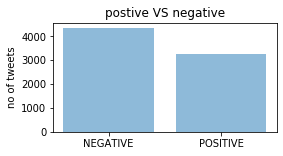

In [5]:
# Read in the dataset
train = pd.read_csv('train.csv', index_col = False)
test = pd.read_csv('test.csv', index_col = False)

train_count = train["target"].value_counts()

objects = ('NEGATIVE', 'POSITIVE')
y_pos = np.arange(len(objects))
 
fig= plt.figure(figsize=(4,2)) 
plt.bar(y_pos, train_count, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('no of tweets')
plt.title('postive VS negative')
plt.show()

In [6]:
pos = train[train['target']==1]['keyword'].value_counts()
neg = train[train['target']==0]['keyword'].value_counts()

neg_pos = pd.concat([pos,neg], axis=1)
neg_pos.columns = ["pos","neg"]
neg_pos.sort_values(by=['pos'], ascending=False)

C:\Users\spard\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


,pos,neg
derailment,39.0,NaN
wreckage,39.0,NaN
outbreak,39.0,1.0
debris,37.0,NaN
oil%20spill,37.0,1.0
...,...,...
epicentre,1.0,11.0
body%20bag,1.0,32.0
electrocute,1.0,31.0
ruin,1.0,36.0


In [7]:
pd.concat([train["target"].value_counts(), (train["target"].value_counts() / train["target"].value_counts().sum() * 100).round(2)], axis=1)

,target,target
0,4342,57.03
1,3271,42.97


In [8]:
print('Training Set Shape = {}'.format(train.shape))

Training Set Shape = (7613, 5)


In [9]:
# Print the header of the train DataFrame
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Let's look at our data, what kind of tweet is classified as disaster

In [10]:
print(train.loc[train["target"] == 1].text[6])
print(train.loc[train["target"] == 1].text[31])
print(train.loc[train["target"] == 1].text[7600])

#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C
Evacuation order lifted for town of Roosevelt: http://t.co/EDyfo6E2PU http://t.co/M5KxLPKFA1


In [11]:
print('Test Set Shape = {}'.format(test.shape))

Test Set Shape = (3263, 4)


In [12]:
# Print info of train DataFrame
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### 1.1 Data type problems

If we analize each variable we can see the following characteristics. From each characteristic we should decide how to work with each variable.

First, we are sure that `id` and `text` are the main variables for the task asked.
For `text` we can apply many transformations to make easier for the models to read this column. In the following steps we are going to try those tools.

Some of the transformation that we need to do is because we found some tweets with `URL`, `symbols`, `emojies`, `hashtag` and `mention`. So, we need to remove, replace or keep, depending on the importance. This analysis will be describe in each step of preprocessing and cleaning.

Then we analize `location` and `keyword`.
- Location: this variable indicates the local position of each tweet. Not only city or country, but also entities, private places and unknown locations. Other information that we see in this variable is that there are almost one unique value for each tweet. At last, we can find more than the half of the values in this columns are missing.
For these reasons we consider that the best aproach for this task is take it out for the model.

- Keyword: this variable seems to be important for the modelling. First, because there are some words that has more weight for negatives tweets and others the other way. Also, knowing how twitter works we can assumne that this word represent kind of a summary of the content.
For these reasons we have to apply some tools to this variable. We will try with this two options.
    - Paste the word to the text, so we can model the `text` column taking in account the keyword
    - Try to model many variables in the same model.

## 2. Baseline NLP model with __text__ column

The first thing we are going to do is to run the model without any change. This way, we will have an idea of the score that we have and see how it change with      each transformation or with other model.

In [9]:
# Import the necessary modules
from sklearn.model_selection import train_test_split

# Create a series to store the labels: y
X = train["text"]
y = train["target"]

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=53)

In [10]:
# Training Naive Bayes (NB) classifier on training data.
from sklearn.naive_bayes import MultinomialNB

text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])
text_clf = text_clf.fit(X_train, y_train)

predicted = text_clf.predict(X_test)

### Pipeline with CountVectorizer + TfIdf + Model

The purpose of a Pipeline is to chain together multiple estimators representing a fixed sequence of steps into a single unit. All estimators in the pipeline...

In [11]:
results_df = pd.DataFrame(columns=['Model', 'Approach', 'F1 Score'])
results_df.loc[len(results_df)] = ['Multinomial NB', 'Baseline', f1_score(predicted, y_test)]
results_df

,Model,Approach,F1 Score
0,Multinomial NB,Baseline,0.713514


Without any data cleaning, only machine learning model is applied through text vectorization and tf-idf transformation, 71% F1-score is obtained. There is a lot to do to improve this score yet, which is the objective of this practice assignment.

## Preprocessing

All the work, explanations, motivations and analysis have to be focused on the NLP aspects. In this sense I would like to see the different ideas and methodologies that we explain in class, properly applied: Data Cleaning, POS Tagging, Dependency Parsing, N-grams, Text classification ideas...

### Dealing with Hashtags
A hashtag is a word or an un-spaced phrase prefixed with the hash symbol (#). These are used to both naming subjects and phrases that are currently in trending topics. For example, #iPad, #news

In [12]:
hash_regex = re.compile(r"#(\w+)")
def hash_repl(match):
	return '__HASH_'+match.group(1).upper()

### User Names
Every Twitter user has a unique username. Any thing directed towards that user can be indicated be writing their username preceded by ‘@’. Thus, these are like proper nouns. For example, @Apple

In [13]:
user_regex = re.compile(r"@(\w+)")
def user_repl(match):
	return '__user_'+match.group(1).upper()

### URLs
Users often share hyperlinks in their tweets. Twitter shortens them using its in-house URL shortening service, like http://t.co/FCWXoUd8 - such links also enables Twitter to alert users if the link leads out of its domain. From the point of view of text classification, a particular URL is not important. However, presence of a URL can be an important feature. Regular expression for detecting a URL is fairly complex because of different types of URLs that can be there, but because of Twitter’s shortening service, we can use a relatively simple regular expression.

In [14]:
url_regex = re.compile(r"(http|https|ftp)://[a-zA-Z0-9\./]+")
def url_repl(match):
	return '__URL_'

### Punctuations
Although not all Punctuations are important from the point of view of classification but some of these, like question mark, exclamation mark can also provide information about the sentiments of the text. We replace every word boundary by a list of relevant punctuations present at that point.

In [15]:
# Spliting by word boundaries
word_bound_regex = re.compile(r"\W+")

# Punctuations
punctuations = \
	[	#('',		['.', ] )	,\
		#('',		[',', ] )	,\
		#('',		['\'', '\"', ] )	,\
		('__PUNC_EXCL',		['!', '¡', ] )	,\
		('__PUNC_QUES',		['?', '¿', ] )	,\
		('__PUNC_ELLP',		['...', '…', ] )	,\
	]

#For punctuation replacement
def punctuations_repl(match):
	text = match.group(0)
	repl = []
	for (key, parr) in punctuations :
		for punc in parr :
			if punc in text:
				repl.append(key)
	if( len(repl)>0 ) :
		return ' '+' '.join(repl)+' '
	else :
		return ' '

### Emoticons and Emojis

Use of emoticons is very prevalent throughout the web, more so on micro-blogging sites. We identify the following emoticons and replace them with a single word. Note that, emoticons are the typographis ones as differ from emojis. 

In [16]:
# Emoticons
emoticons = \
	[	('__EMOT_SMILEY',	[':-)', ':)', '(:', '(-:', ] )	,\
		('__EMOT_LAUGH',		[':-D', ':D', 'X-D', 'XD', 'xD', ] )	,\
		('__EMOT_LOVE',		['<3', ':\*', ] )	,\
		('__EMOT_WINK',		[';-)', ';)', ';-D', ';D', '(;', '(-;', ] )	,\
		('__EMOT_FROWN',		[':-(', ':(', '(:', '(-:', ] )	,\
		('__EMOT_CRY',		[':,(', ':\'(', ':"(', ':(('] )	,\
	]
    
def escape_paren(arr):
	return [text.replace(')', '[)}\]]').replace('(', '[({\[]') for text in arr]

def regex_union(arr):
	return '(' + '|'.join( arr ) + ')'

emoticons_regex = [ (repl, re.compile(regex_union(escape_paren(regx))) ) for (repl, regx) in emoticons ]

# Emojis
# from emoji library, we will use demojize() function

### Repetitions
People often use repeating characters while using colloquial language, like "I’m in a hurrryyyyy", "We won, yaaayyyyy!" As our final pre-processing step, we replace characters repeating more than twice as two characters.

In [17]:
# Repeating words like hurrrryyyyyy
rpt_regex = re.compile(r"(.)\1{1,}", re.IGNORECASE);
def rpt_repl(match):
	return match.group(1)+match.group(1)

### Stemming
We will now stemmize the words in the tweets by applying the Porter Stemmer seen in class. This stemmer was very widely used and became and remains the de facto standard algorithm used for English stemming. It offers excellent trade-off between speed, readability, and accuracy.

NLTK has its own implementation of the stemmer

### Lemmatization

The difference between stemming and lemmatization is, lemmatization considers the context and converts the word to its meaningful base form, whereas stemming just removes the last few characters, often leading to incorrect meanings and spelling errors.

In [18]:
import emoji
# Wrapper function that encloses all the processing procedures
def processAll(text):

    # remove usernames:         text = re.sub('@[^\s]+', '', text)
    # remove only hasgtag sign: text = re.sub(r'#([^\s]+)', r'\1', text) 
    # convert emojis to text
    text = emoji.demojize(text)
    # apply functions defined above
    text = re.sub( hash_regex, hash_repl, text )
    text = re.sub( user_regex, user_repl, text)
    text = re.sub( url_regex, ' __URL ', text )

    for (repl, regx) in emoticons_regex :
        text = re.sub(regx, ' '+repl+' ', text)
      
    text = text.replace('\'','')
    
    text = re.sub( word_bound_regex , punctuations_repl, text )
    text = re.sub( rpt_regex, rpt_repl, text )

    words = text.split()

    # eliminate words shorter than 3 chars
    text = [word if(word[0:2]=='__') else word.lower() for word in text.split() if len(word) >= 3]
    # lemmatize
    lemmatizer=WordNetLemmatizer()
    text = [lemmatizer.lemmatize(w) for w in text]
    # stemming
    stemmer = nltk.stem.PorterStemmer()
    text = [stemmer.stem(w) for w in text]                
    
    return(" ".join(text))

To obtain a new column in our dataframe with the processed text

In [19]:
train['processed_tweet'] = train.text.apply(processAll)
train['processed_tweet'].head()

0    our deed are the reason thi __hash_earthquak m...
1                    forest fire near rong sask canada
2    all resid ask shelter place are be notifi offi...
3    peopl receiv __hash_wildfir evacu order califo...
4    just got sent thi photo from rubi __hash_alask...
Name: processed_tweet, dtype: object

In [20]:
X = train["processed_tweet"]
y = train["target"]

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=53)

text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])
text_clf = text_clf.fit(X_train, y_train)

predicted = text_clf.predict(X_test)

results_df.loc[len(results_df)] = ['Multinomial NB', 'Baseline with Processed Tweet', f1_score(predicted, y_test)]
results_df

,Model,Approach,F1 Score
0,Multinomial NB,Baseline,0.713514
1,Multinomial NB,Baseline with Processed Tweet,0.717785


### Stopwords

Stop words are the most common words in a language like “the”, “a”, “at”, “for”, “above”, “on”, “is”, “all”. These words do not provide any meaning and are usually removed from texts. We can remove these stop words using nltk library


In [21]:
# Let's see the entire tweet
tokens = word_tokenize(train.text[2])
print(tokens)

['All', 'residents', 'asked', 'to', "'shelter", 'in', 'place', "'", 'are', 'being', 'notified', 'by', 'officers', '.', 'No', 'other', 'evacuation', 'or', 'shelter', 'in', 'place', 'orders', 'are', 'expected']


In [22]:
# The same tweet from which stopwords are excluded:
stop_words = set(stopwords.words("english"))
tokens = [w for w in tokens if not w in stop_words]
print(tokens)           

['All', 'residents', 'asked', "'shelter", 'place', "'", 'notified', 'officers', '.', 'No', 'evacuation', 'shelter', 'place', 'orders', 'expected']


### Further Text Pre Processing

* Negations to Antonyms
* POS-tagging
* N-grams
...

In [23]:
from nltk.corpus import wordnet
def convert_to_antonym(sentence):
    words = nltk.word_tokenize(sentence)
    new_words = []
    temp_word = ''
    for word in words:
        antonyms = []
        if word == 'not':
            temp_word = 'not_'
        elif temp_word == 'not_':
            for syn in wordnet.synsets(word):
                for s in syn.lemmas():
                    for a in s.antonyms():
                        antonyms.append(a.name())
            if len(antonyms) >= 1:
                word = antonyms[0]
            else:
                word = temp_word + word # when antonym is not found, it will
                                    # remain not_happy
            
            temp_word = ''
        if word != 'not':
            new_words.append(word)
    return ' '.join(new_words)

In [24]:
train['extra_processed_text'] = train['processed_tweet'].apply(lambda x: convert_to_antonym(x))
train['extra_processed_text'].head()

0    our deed are the reason thi __hash_earthquak m...
1                    forest fire near rong sask canada
2    all resid ask shelter place are be notifi offi...
3    peopl receiv __hash_wildfir evacu order califo...
4    just got sent thi photo from rubi __hash_alask...
Name: extra_processed_text, dtype: object

Algorithms to be applied are: ***NB, Multinomial NB, MaxEnt, SVM, Stochastic Gradient Descent, RF, Logistic Regression***

Let's test our model and see how well it does on the training data. For this we'll use cross-validation - where we train on a portion of the known data, then validate it with the rest. If we do this several times (with different portions) we can get a good idea for how a particular model or method performs.

The metric for this competition is `F1`, so let's use that here.

Let's modify pipeline by dealing with __stop words__, fitting the model on new text field. This improves the score slightly.

In [25]:
X = train["extra_processed_text"]
y = train["target"]

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=53)

text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')), 
                    ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])
text_clf = text_clf.fit(X_train, y_train)

predicted = text_clf.predict(X_test)

results_df.loc[len(results_df)] = ['Multinomial NB', 'Extra Processed Tweet', f1_score(predicted, y_test)]
results_df

,Model,Approach,F1 Score
0,Multinomial NB,Baseline,0.713514
1,Multinomial NB,Baseline with Processed Tweet,0.717785
2,Multinomial NB,Extra Processed Tweet,0.731205


So far, thanks to the __data cleaning__ we leveraged the score by around 4%.

### SVM

SVM seems to outperform Multinomial NB model.

In [26]:
# Classifier - Algorithm - SVM
from sklearn import svm
from sklearn.feature_extraction.text import HashingVectorizer

SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')

text_clf_svm = Pipeline([('vect', CountVectorizer(stop_words='english')), ('tfidf', TfidfTransformer()),
                         ('clf-svm', SVM)])

text_clf_svm = text_clf_svm.fit(X_train, y_train)
predicted_svm = text_clf_svm.predict(X_test)

results_df.loc[len(results_df)] = ['Support Vector Machine', 'Extra Processed Tweets', f1_score(predicted_svm, y_test)]
results_df

,Model,Approach,F1 Score
0,Multinomial NB,Baseline,0.713514
1,Multinomial NB,Baseline with Processed Tweet,0.717785
2,Multinomial NB,Extra Processed Tweet,0.731205
3,Support Vector Machine,Extra Processed Tweets,0.750730


### **Stochastic Gradient Descent**

In [27]:
from sklearn.linear_model import SGDClassifier

text_clf_sgd = Pipeline([('vect', CountVectorizer(stop_words='english')), ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=5, random_state=42))])

text_clf_sgd = text_clf_sgd.fit(X_train, y_train)
predicted = text_clf_sgd.predict(X_test)

results_df.loc[len(results_df)] = ['Stochastic Gradient Descent', 'Extra Processed Tweet', f1_score(predicted, y_test)]
results_df

,Model,Approach,F1 Score
0,Multinomial NB,Baseline,0.713514
1,Multinomial NB,Baseline with Processed Tweet,0.717785
2,Multinomial NB,Extra Processed Tweet,0.731205
3,Support Vector Machine,Extra Processed Tweets,0.750730
4,Stochastic Gradient Descent,Extra Processed Tweet,0.682353


### **Logistic Regression**

In [28]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression

# Fitting classifier to the Training set
text_clf_lr = Pipeline([('vect', CountVectorizer(stop_words='english')), ('tfidf', TfidfTransformer()),
                         ('clf-logreg', LogisticRegression(random_state=0))])

text_clf_lr = text_clf_lr.fit(X_train, y_train)
predicted_lr = text_clf_lr.predict(X_test)

results_df.loc[len(results_df)] = ['Logistic Regression', 'Extra Processed Tweet', f1_score(predicted_lr, y_test)]
results_df

,Model,Approach,F1 Score
0,Multinomial NB,Baseline,0.713514
1,Multinomial NB,Baseline with Processed Tweet,0.717785
2,Multinomial NB,Extra Processed Tweet,0.731205
3,Support Vector Machine,Extra Processed Tweets,0.750730
4,Stochastic Gradient Descent,Extra Processed Tweet,0.682353
5,Logistic Regression,Extra Processed Tweet,0.741483


### **Random Forest**

In [29]:
#RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(n_estimators=500, criterion="entropy", random_state=42)
text_clf_rfc = Pipeline([('vect', CountVectorizer(stop_words='english')), ('tfidf', TfidfTransformer()),
                ('clf-rfc', RFC)])
#fit and predict                         
text_clf_rfc = text_clf_rfc.fit(X_train, y_train)
predicted_rfc = text_clf_rfc.predict(X_test)

results_df.loc[len(results_df)] = ['Random Forest', 'Extra Processed Tweet', f1_score(predicted_rfc, y_test)]
results_df

,Model,Approach,F1 Score
0,Multinomial NB,Baseline,0.713514
1,Multinomial NB,Baseline with Processed Tweet,0.717785
2,Multinomial NB,Extra Processed Tweet,0.731205
3,Support Vector Machine,Extra Processed Tweets,0.750730
4,Stochastic Gradient Descent,Extra Processed Tweet,0.682353
5,Logistic Regression,Extra Processed Tweet,0.741483
6,Random Forest,Extra Processed Tweet,0.697799


## More Features?

In [30]:
train["processed_list"] = train['extra_processed_text'].apply(lambda x: x.split())

### N-gram Features

N-gram refers to an n-long sequence of words. Probabilistic Language Models based on Unigrams, Bigrams and Trigrams can be successfully used to predict the next word given a current context of words. In the domain of sentiment analysis, the performance of N-grams is unclear.

In [31]:
# Wrapper function that encloses all the n-grams procedures

def get_word_features(words):
    bag = {}
    words_uni = [ 'has(%s)'% ug for ug in words ]
    words_bi  = [ 'has(%s)'% ','.join(map(str,bg)) for bg in nltk.bigrams(words) ]
    words_tri = [ 'has(%s)'% ','.join(map(str,tg)) for tg in nltk.trigrams(words) ]
    
    for f in words_uni+words_bi+words_tri:
        bag[f] = 1

    return bag

### POS-Tagging

With POS Tagging we can get the category of each word. Some of these categories are more interesting in order to infer the sentiment of given tweet. For example, adjectives are expected to carry most sentiment information than adverbs. In a similar way, some particular names can carry a positive or negative implication for particular domain

In [32]:
def get_pos_features(words):
    tags = {}
    tagged_words = [ 'has(%s)'% w+'_'+tag for w,tag in nltk.pos_tag(words)]
    
    for tw in tagged_words:
        tags[tw] = 1

    return tags

In [33]:
train.processed_list

0       [our, deed, are, the, reason, thi, __hash_eart...
1                [forest, fire, near, rong, sask, canada]
2       [all, resid, ask, shelter, place, are, be, not...
3       [peopl, receiv, __hash_wildfir, evacu, order, ...
4       [just, got, sent, thi, photo, from, rubi, __ha...
                              ...                        
7608    [two, giant, crane, hold, bridg, collaps, into...
7609    [__user_aria_ahrari, __user_thetawniest, the, ...
7610        [utc, __punc_qu, 5km, volcano, hawaii, __url]
7611    [polic, investig, after, bike, collid, with, c...
7612    [the, latest, more, home, raze, northern, cali...
Name: processed_list, Length: 7613, dtype: object

In [34]:
# Wrapper function for the extraction of features we mentioned above
def extract_features(text):
    features = {}

    word_features = get_word_features(text)
    features.update( word_features )
    
    pos_features = get_pos_features(text)
    features.update( pos_features )

    return features

In [35]:
#import nltk
#nltk.download('averaged_perceptron_tagger')

In [43]:
train.processed_list

0       [our, deed, are, the, reason, thi, __hash_eart...
1                [forest, fire, near, rong, sask, canada]
2       [all, resid, ask, shelter, place, are, be, not...
3       [peopl, receiv, __hash_wildfir, evacu, order, ...
4       [just, got, sent, thi, photo, from, rubi, __ha...
                              ...                        
7608    [two, giant, crane, hold, bridg, collaps, into...
7609    [__user_aria_ahrari, __user_thetawniest, the, ...
7610        [utc, __punc_qu, 5km, volcano, hawaii, __url]
7611    [polic, investig, after, bike, collid, with, c...
7612    [the, latest, more, home, raze, northern, cali...
Name: processed_list, Length: 7613, dtype: object

In [36]:
train['processed_tweet_features'] = train["processed_list"].apply(extract_features)
train[['text','processed_tweet_features']].head()

,text,processed_tweet_features
0,Our Deeds are the Reason of this #earthquake M...,"{'has(our)': 1, 'has(deed)': 1, 'has(are)': 1,..."
1,Forest fire near La Ronge Sask. Canada,"{'has(forest)': 1, 'has(fire)': 1, 'has(near)'..."
2,All residents asked to 'shelter in place' are ...,"{'has(all)': 1, 'has(resid)': 1, 'has(ask)': 1..."
3,"13,000 people receive #wildfires evacuation or...","{'has(peopl)': 1, 'has(receiv)': 1, 'has(__has..."
4,Just got sent this photo from Ruby #Alaska as ...,"{'has(just)': 1, 'has(got)': 1, 'has(sent)': 1..."


In [44]:
training_size = 4000
train_tweets = [(processed_list, target) for processed_list, target in train[['processed_list', 'target']].values[:training_size]]
validation_tweets  = [(processed_list, target) for processed_list, 
target in train[['processed_list', 'target']].values[training_size:]]

In [45]:
# Apply the data processing and cleaning extraction methodologies
v_train = nltk.classify.apply_features(extract_features,train_tweets)
v_validation  = nltk.classify.apply_features(extract_features,validation_tweets)

In [46]:
print("For the tweet = ", train.text.values[0])
print(" ")
print("The following features has been created:")
print(" ")
print(v_train[0][0])

For the tweet =  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
 
The following features has been created:
 
{'has(our)': 1, 'has(deed)': 1, 'has(are)': 1, 'has(the)': 1, 'has(reason)': 1, 'has(thi)': 1, 'has(__hash_earthquak)': 1, 'has(may)': 1, 'has(allah)': 1, 'has(forgiv)': 1, 'has(all)': 1, 'has(our,deed)': 1, 'has(deed,are)': 1, 'has(are,the)': 1, 'has(the,reason)': 1, 'has(reason,thi)': 1, 'has(thi,__hash_earthquak)': 1, 'has(__hash_earthquak,may)': 1, 'has(may,allah)': 1, 'has(allah,forgiv)': 1, 'has(forgiv,all)': 1, 'has(our,deed,are)': 1, 'has(deed,are,the)': 1, 'has(are,the,reason)': 1, 'has(the,reason,thi)': 1, 'has(reason,thi,__hash_earthquak)': 1, 'has(thi,__hash_earthquak,may)': 1, 'has(__hash_earthquak,may,allah)': 1, 'has(may,allah,forgiv)': 1, 'has(allah,forgiv,all)': 1, 'has(our)_PRP$': 1, 'has(deed)_NN': 1, 'has(are)_VBP': 1, 'has(the)_DT': 1, 'has(reason)_NN': 1, 'has(thi)_NN': 1, 'has(__hash_earthquak)_NN': 1, 'has(may)_MD': 1, 'has(allah)_V

### Let's Try ***Naive Bayes*** for this Extracted Features Approach

In [47]:
nb_classifier = nltk.classify.NaiveBayesClassifier
nb_class = nb_classifier.train(v_train)

In [48]:
print("Accuracy of the model = ", nltk.classify.accuracy(nb_class, v_validation))

Accuracy of the model =  0.7251591475228342


#### Most Representative Features

The NLTK classifier object allows us to see the most representative features

In [305]:
nb_class.show_most_informative_features(25)

Most Informative Features
               has(atom) = 1                   1 : 0      =     47.6 : 1.0
          has(atom,bomb) = 1                   1 : 0      =     42.8 : 1.0
            has(reunion) = 1                   1 : 0      =     28.4 : 1.0
         has(reunion)_NN = 1                   1 : 0      =     28.4 : 1.0
     has(anniversari)_NN = 1                   1 : 0      =     24.5 : 1.0
         has(california) = 1                   1 : 0      =     22.2 : 1.0
      has(california)_NN = 1                   1 : 0      =     22.2 : 1.0
               has(mark) = 1                   1 : 0      =     19.7 : 1.0
        has(aircraft)_NN = 1                   1 : 0      =     18.7 : 1.0
           has(aircraft) = 1                   1 : 0      =     18.7 : 1.0
         has(cross,bodi) = 1                   0 : 1      =     18.3 : 1.0
           has(train)_NN = 1                   1 : 0      =     18.2 : 1.0
        has(anniversari) = 1                   1 : 0      =     18.2 : 1.0

## MaxEnt Classifier

Let's try a more sophisticated classifier to see if we can boost the classification performance. In particular we will apply a Maximum Entropy Classifier. 


This classifier works by finding a probability distribution that maximizes the likelihood of testable data. This probability function is parameterized by weight vector. The optimal value of which can be found out using the method of Lagrange multipliers.

In [ ]:
max_ent_classifier = nltk.classify.MaxentClassifier
max_ent_class = max_ent_classifier.train(v_train, algorithm='GIS', max_iter=25)

In [ ]:
print("Accuracy of the model = ", nltk.classify.accuracy(max_ent_class, v_validation))

With ***Max Entropy*** we obtained just a little higher score.

So far, SVM seems to be the best model based on the score. Now let's try if we there is room to improve anymore via hyperparameter search.

Going back to n-grams, we try parameters {'`vect__ngram_range`': [(1, 1), (1, 2)]} for **SVM** model and got even higher score. Note that, longer n-gram does not always guarantee improvement.

## Selected Model: `SVM with Bigram Tweets`

In [51]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')

text_clf_svm = Pipeline([('vect', CountVectorizer(stop_words='english',ngram_range=(1, 2))), ('tfidf', TfidfTransformer()),
                         ('clf-svm', SVM)])

text_clf_svm = text_clf_svm.fit(X_train, y_train)
predicted_svm = text_clf_svm.predict(X_test)

results_df.loc[len(results_df)] = ['Support Vector Machine', 'Bigrams', f1_score(predicted_svm, y_test)]
results_df

,Model,Approach,F1 Score
0,Multinomial NB,Baseline,0.713514
1,Multinomial NB,Baseline with Processed Tweet,0.717785
2,Multinomial NB,Extra Processed Tweet,0.731205
3,Support Vector Machine,Extra Processed Tweets,0.750730
4,Stochastic Gradient Descent,Extra Processed Tweet,0.682353
5,Logistic Regression,Extra Processed Tweet,0.741483
6,Random Forest,Extra Processed Tweet,0.697799
7,Support Vector Machine,Bigrams,0.752267


### ***Prediction on Test CSV***

In [193]:
sample_sub=pd.read_csv('sample_submission.csv')

df_test= test.drop(["id", "keyword","location"], axis=1)

df_test['processed_tweet'] = df_test.text.apply(processAll)

df_test['extra_processed_tweet'] = df_test['processed_tweet'].apply(lambda x: convert_to_antonym(x))

text_clf_svm = Pipeline([('vect', CountVectorizer(stop_words='english', ngram_range=(1,2))), ('tfidf', TfidfTransformer()), ('clf-svm', SVM)])

text_clf_svm = text_clf_svm.fit(X_train, y_train)

y_pred = text_clf_svm.predict(df_test['extra_processed_tweet'])

y_pred=np.round(y_pred).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pred})
sub.to_csv('submission.csv',index=False)

In [33]:
for df in [train, test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

In [35]:
# mean_word_length
train['mean_word_length'] = train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [36]:
# char_count
train['char_count'] = train['text'].apply(lambda x: len(str(x)))

In [37]:
train = train[["char_count", 'mean_word_length', "extra_processed_text"]]

In [52]:
train.head()

,id,keyword,location,text,target,processed_tweet,extra_processed_text,processed_list,processed_tweet_features
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deed are the reason thi __hash_earthquak m...,our deed are the reason thi __hash_earthquak m...,"[our, deed, are, the, reason, thi, __hash_eart...","{'has(our)': 1, 'has(deed)': 1, 'has(are)': 1,..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near rong sask canada,forest fire near rong sask canada,"[forest, fire, near, rong, sask, canada]","{'has(forest)': 1, 'has(fire)': 1, 'has(near)'..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all resid ask shelter place are be notifi offi...,all resid ask shelter place are be notifi offi...,"[all, resid, ask, shelter, place, are, be, not...","{'has(all)': 1, 'has(resid)': 1, 'has(ask)': 1..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,peopl receiv __hash_wildfir evacu order califo...,peopl receiv __hash_wildfir evacu order califo...,"[peopl, receiv, __hash_wildfir, evacu, order, ...","{'has(peopl)': 1, 'has(receiv)': 1, 'has(__has..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent thi photo from rubi __hash_alask...,just got sent thi photo from rubi __hash_alask...,"[just, got, sent, thi, photo, from, rubi, __ha...","{'has(just)': 1, 'has(got)': 1, 'has(sent)': 1..."


In [29]:
#instantiate CountVectorizer()
cv=CountVectorizer(stop_words='english', ngram_range=(1, 2))
 
# this steps generates word counts for the words in your docs
word_count_vector=cv.fit_transform(train["text"])

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)


TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [30]:
word_count_vector

<7613x73894 sparse matrix of type '<class 'numpy.int64'>'
	with 142761 stored elements in Compressed Sparse Row format>

## **Diagnosing data cleaning problems using simple `pandas` and visualizations** 

## *__Word Cloud__*

To represent word usage in a document by resizing individual words proportionally to its frequency, and then presenting them in random arrangement.


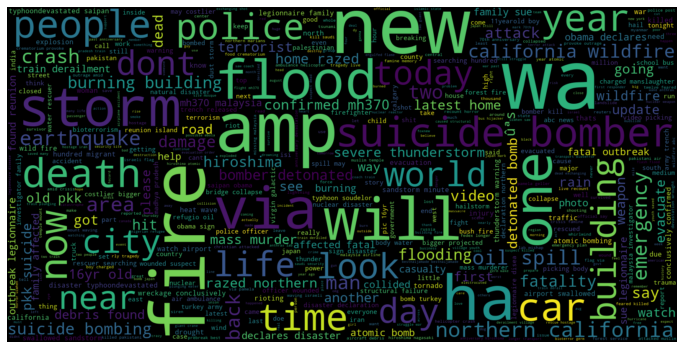

In [53]:
# Wrapper function that encloses to highlight meaningful words to be shown in wordCloud
import string

def processforCloud(text):

    text = [char for char in text if char not in string.punctuation]
    text = ''.join(text)
    text = re.sub('@[^\s]+', '', text)
    text = re.sub(r'#([^\s]+)', r'\1', text) 
    text = re.sub( url_regex, '',text )
    text = text.replace('\'','')
    text = re.sub( word_bound_regex , punctuations_repl, text )
    text = re.sub( rpt_regex, rpt_repl, text )
    words = text.split()
    # eliminate words shorter than 3 chars
    text = [word if(word[0:2]=='__') else word.lower() for word in text.split() if len(word) >= 3]
    # lemmatize
    lemmatizer=WordNetLemmatizer()
    text = [lemmatizer.lemmatize(w) for w in text]
    
    return(" ".join(text))

train['forwordcloud'] = train['text'].apply(lambda x: processforCloud(x))

# most frequent words with disaster tweets
from wordcloud import WordCloud, STOPWORDS

dis_tweets = train[train.target == 1]
dis_string = []
for t in dis_tweets.forwordcloud:
    dis_string.append(t)
dis_string = pd.Series(dis_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800, max_font_size=200, stopwords = STOPWORDS, max_words=500).generate(dis_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

train.drop('forwordcloud', axis=1, inplace=True)

### What about other fields?

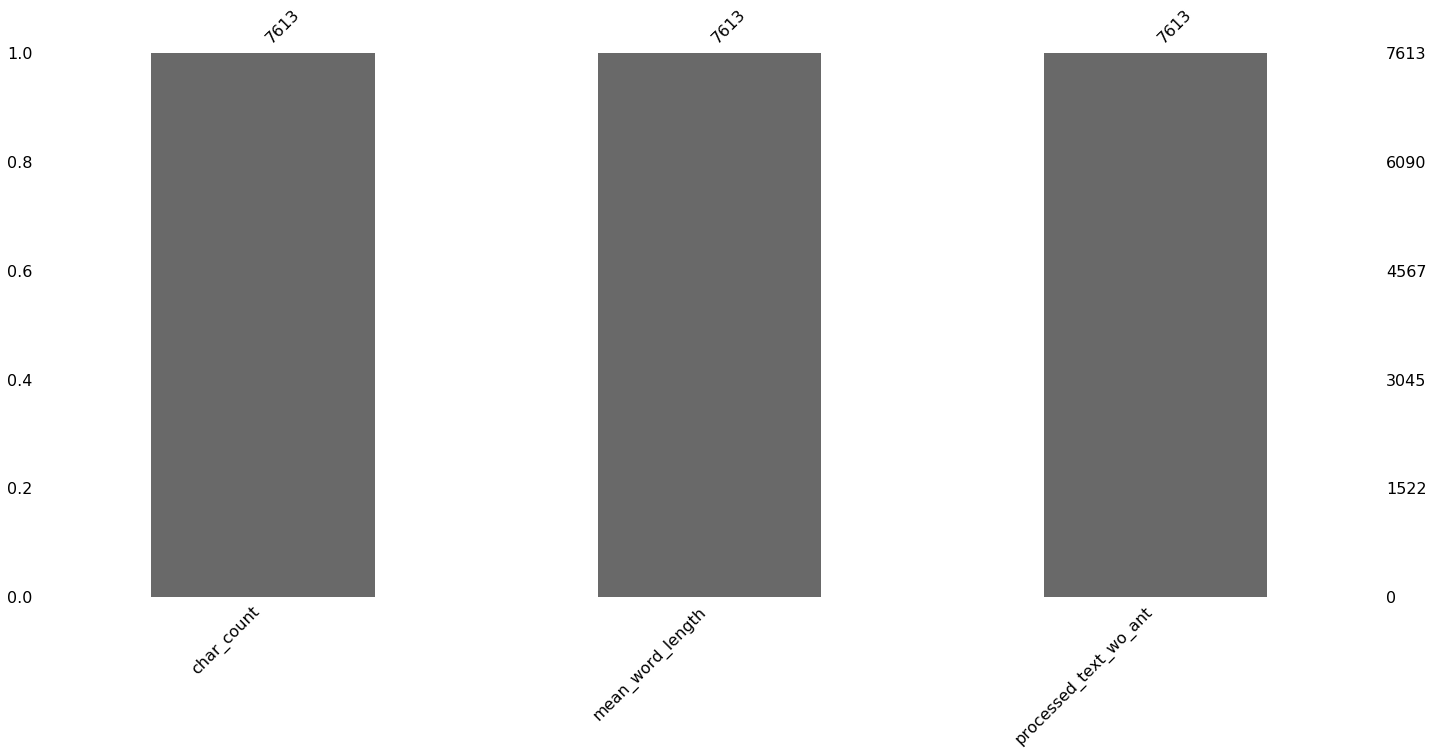

In [77]:
# Missingness for train set barplot
msno.bar(train)

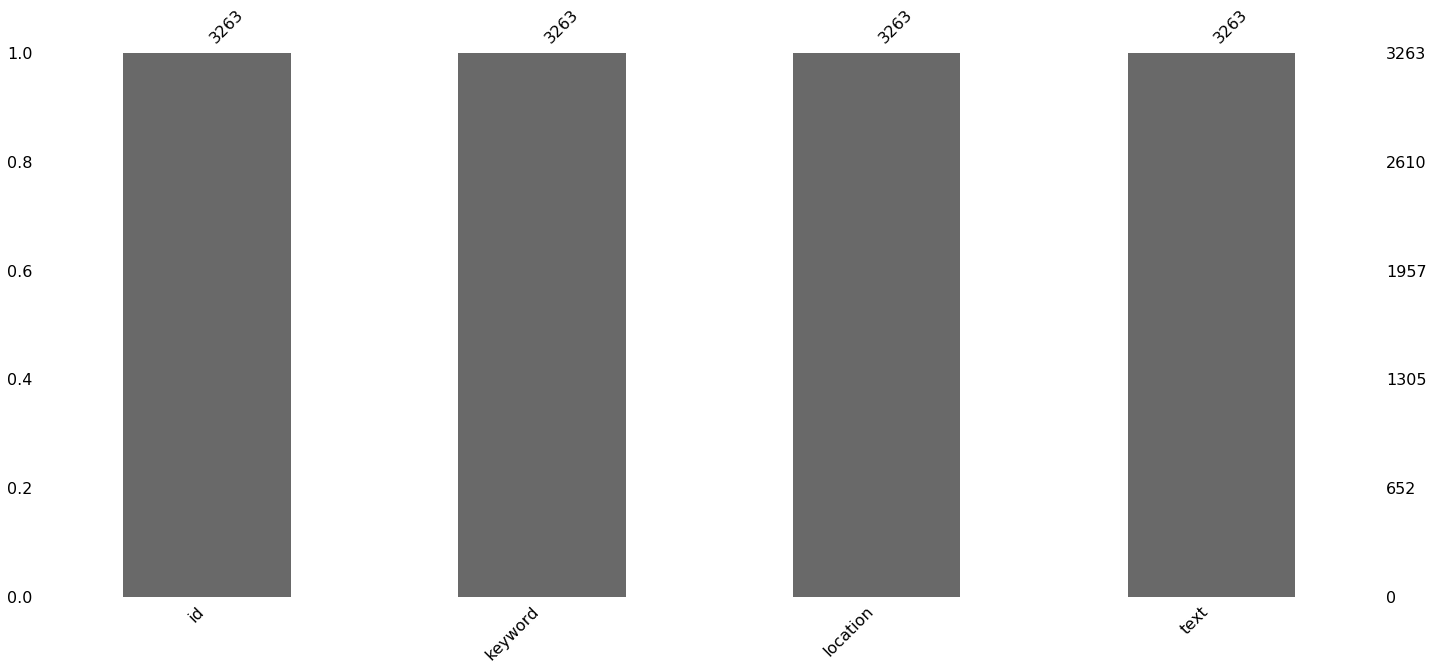

In [78]:
# Missingness for test set barplot
msno.bar(test)

In [54]:
print(f'Number of unique values in keyword = {train["keyword"].nunique()} (Training) - {test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {train["location"].nunique()} (Training) - {test["location"].nunique()} (Test)')

Number of unique values in keyword = 221 (Training) - 221 (Test)
Number of unique values in location = 3341 (Training) - 1602 (Test)


In [55]:
for df in [train, test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

Attributes are different for ___location___ in train and test sets. Thus, we prefer to eliminate it from training set.

Fortunately, there is signal in ___keyword___ because some of those words can only be used in one context. Keywords have very different tweet counts and target means. Keyword can be used as a feature by itself or as a word added to the text. Every single keyword in training set exists in test set. If training and test set are from the same sample, it is also possible to use target encoding on keyword.

In [56]:
train.keyword.unique()

array(['no_keyword', 'ablaze', 'accident', 'aftershock',
       'airplane%20accident', 'ambulance', 'annihilated', 'annihilation',
       'apocalypse', 'armageddon', 'army', 'arson', 'arsonist', 'attack',
       'attacked', 'avalanche', 'battle', 'bioterror', 'bioterrorism',
       'blaze', 'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard',
       'blood', 'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'dera

In [57]:
train.location.unique()

array(['no_location', 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

### Target Field

When we look at target field, training set has approximately equal distribution of it. Therefore, we do not need to stratify or worry about any other balancing process.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025D93CBD4C8>]],
      dtype=object)

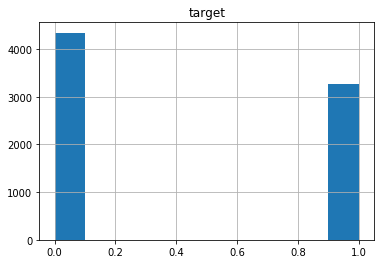

In [58]:
train.hist('target')

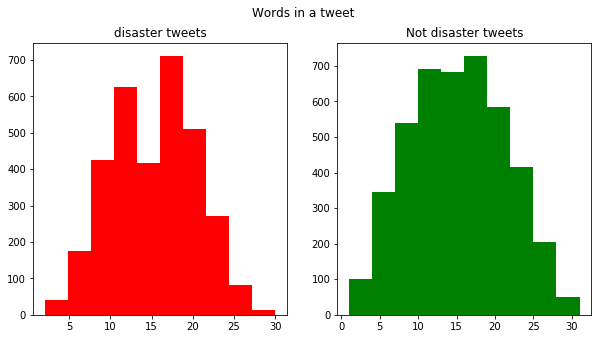

In [59]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

train_wordlen=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(train_wordlen,color='red')
ax1.set_title('disaster tweets')
train_wordlen=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(train_wordlen,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

From the histograms below, we see that disaster tweets are written with longer words compared to non-disaster. This feature can be used for the model.

Text(0.5, 0.98, 'Average word length in each tweet')

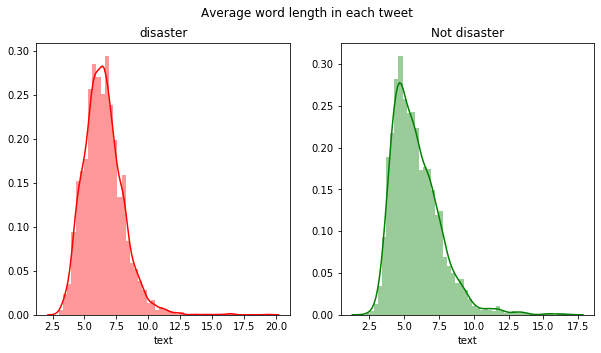

In [60]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

Looking at the missing data in the DataFrame - we can see that `number_of_reviews` across all missing rows is 0. We can infer that these listings have never been visited - hence could be inferred they're inactive/have never been visited. 

We can impute them as following:

- Set `NaN` for `reviews_per_month`, `number_of_stays`, `5_stars` to 0.
- Since a `rating` did not happen, let's keep the column as is - but create a new column named `rated` that takes in `1` if yes, `0` if no.
- We will also leave `last_review` as is.


In [86]:
train.head()

,char_count,mean_word_length,processed_text_wo_ant
0,69,4.384615,our deed are the reason thi __hash_earthquak m...
1,38,4.571429,forest fire near rong sask canada
2,133,5.090909,all resid ask shelter place are be notifi offi...
3,65,7.125000,peopl receiv __hash_wildfir evacu order califo...
4,88,4.500000,just got sent thi photo from rubi __hash_alask...


In [61]:
# Visualize relationship average word length and disaster
sns.boxplot(x = 'target', y = 'mean_word_length', data = train)
plt.ylim(0,20)
plt.xlabel('Target')
plt.ylabel('Avg Word Length')
plt.show()

ValueError: Could not interpret input 'mean_word_length'

#### **Task:** Let's check if there are any duplicate data

In [62]:
# Find duplicates in train set
duplicates = train.duplicated(subset="id", keep="first")
print("There are {} duplicate records in the test set.".format(train[duplicates].shape[0]))

There are 0 duplicate records in the test set.
